# Segmentation des clients du site E-Commerce Olist

Olist souhaite obtenir une segmentation de ses clients utilisable au quotidien par leur équipe marketing dans leurs campagnes de communication. L'objectif est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

Nous allons donc fournir ici une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous devrons également fournir une analyse de la stabilité des segments au cours du temps (dans le but d'établir un contrat de maintenance).

Nous utilisererons donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaire

Faire une PCA
- Projéte les individus 
- Cercle de correlation


Modélisation
- Kmeans
- Déterminer le nombre de clusters
- Regarder et analyser les clusters : Très important de comprendre ce qui distingue nos différents groupes


Repasser sur les données et ajouter quelques features au dataset
- Review_score_moyen
- différence en date d'achat et date de livraison
- Retard de livraison : date prévu - date effective de livraison


Etape de Maintenance

In [ ]:
#!pip install kmodes

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns


from sklearn import (preprocessing, manifold,decomposition)
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import pairwise_distances_argmin_min

In [5]:
import warnings
warnings.filterwarnings("ignore")


# Affichage d'un maximum de les lignes et colonnes
pd.set_option('display.max_column', 200)
#pd.set_option('display.max_rows', 500)

In [6]:
###PCA Decomposition###
#######################
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [209]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

In [7]:
def display_scree_plot(pca):
    '''
        Plots the scree plot for the given pca
        components.

        ----------------
        - pca : A PCA object
                The result of a PCA decomposition

        Returns
        ---------------
        _
    '''

    # Constants for the plot
    TITLE_SIZE = 20
    LABEL_SIZE = 15
    LABEL_PAD = 20

    plt.subplots(figsize=(10, 8))

    scree = pca.explained_variance_ratio_ * 100

    plt.bar(np.arange(len(scree))+1, scree)

    plt.plot(np.arange(len(scree))+1,
             scree.cumsum(), c="red", marker='o')

    plt.xlabel("Rang de l'axe d'inertie",
               fontsize=LABEL_SIZE,
               labelpad=LABEL_PAD)

    plt.ylabel("% d'inertie",
               fontsize=LABEL_SIZE,
               labelpad=LABEL_PAD)

    plt.title("Eboulis des valeurs propres\n",
              fontsize=TITLE_SIZE, 
              )

    plt.show(block=False)

In [46]:
import plotly.graph_objs as go


def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [ ]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

## Préparation des données 

In [143]:
olist_customer_data = pd.read_csv("olist_customer_data.csv")
print(olist_customer_data.shape)
#olist_data.head()

(91019, 38)


In [144]:
olist_data = olist_customer_data.copy()

cols_toDrop = ["customer_unique_id", "most_purchase_month", "most_purchase_dayofweek", 
               'mean_price_order','min_order_value', 'max_order_value','total_items']

# suppression des variables
olist_data.drop(columns= cols_toDrop, inplace=True)
olist_data.shape

(91019, 31)

In [219]:
data = olist_data.copy()
#data.head()
data.head()

,nb_orders_F,total_payment_value_M,mean_payment_sequential,mean_payment_installments,mean_review_score,means_delivery_vs_estimated,mean_delevery_days,mean_delay_days,mean_distance_sel_cust,freight_ratio,mean_order_value,customer_seniority_R,nb_product,mean_freight_value,most_purchase_category,most_payment_used,often_is_delayed,most_purchase_region,most_purchase_month_N,most_purchase_dayofweek_N,most_purchase_timeday,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby
0,1,141.90,1.0,8.0,5.0,4.0,4.0,-5.0,1.034073,0.08,141.90,111,1,12.00,home_furniture,Credit Card,False,Southeast,May,Thu,Morning,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,27.19,1.0,1.0,4.0,4.0,1.0,-5.0,0.221438,0.30,27.19,114,1,8.29,health_beauty,Credit Card,False,Southeast,May,Mon,Morning,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,86.22,1.0,8.0,3.0,1.0,23.0,-2.0,4.720718,0.20,86.22,536,1,17.22,other,Credit Card,False,South,Mar,Fri,Night,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,43.62,1.0,4.0,4.0,11.0,19.0,-12.0,22.319992,0.40,43.62,320,1,17.63,technology,Credit Card,False,North,Oct,Thu,Night,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,196.89,1.0,6.0,5.0,7.0,11.0,-8.0,1.505514,0.09,196.89,287,1,16.89,technology,Credit Card,False,Southeast,Nov,Tue,Night,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### HeatMap pour vérifier la correlation entre les variables

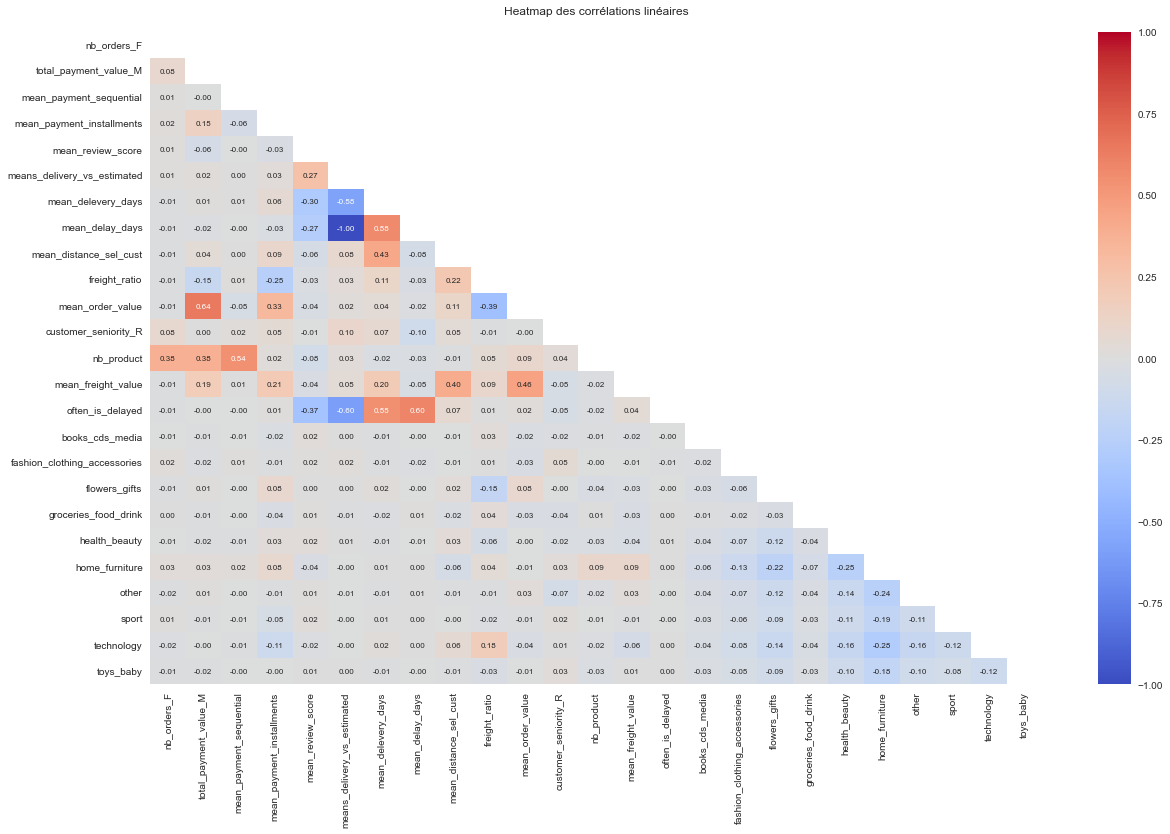

In [146]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20,12))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, 
                 center=0, 
                 cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

In [ ]:
#sns.pairplot(data)

# Modélisation des variables num. avec les catégories de produits inclus

In [149]:
product_cat = [ 'books_cds_media', 'fashion_clothing_accessories', 'flowers_gifts', 'groceries_food_drink', 
               'health_beauty','home_furniture', 'other', 'sport', 'technology', 'toys_baby']

print(len(product_cat))

10


In [150]:
numerical_features = data.select_dtypes(include=['int64','float64', 'uint8'])
categorical_features = data.select_dtypes(exclude=['int64', 'float64', 'uint8'])

In [151]:
print(numerical_features.shape)
numerical_features.head()
#categorical_features.head()

(91019, 24)


,nb_orders_F,total_payment_value_M,mean_payment_sequential,mean_payment_installments,mean_review_score,means_delivery_vs_estimated,mean_delevery_days,mean_delay_days,mean_distance_sel_cust,freight_ratio,mean_order_value,customer_seniority_R,nb_product,mean_freight_value,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby
0,1,141.90,1.0,8.0,5.0,4.0,4.0,-5.0,1.034073,0.08,141.90,111,1,12.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,27.19,1.0,1.0,4.0,4.0,1.0,-5.0,0.221438,0.30,27.19,114,1,8.29,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,86.22,1.0,8.0,3.0,1.0,23.0,-2.0,4.720718,0.20,86.22,536,1,17.22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,43.62,1.0,4.0,4.0,11.0,19.0,-12.0,22.319992,0.40,43.62,320,1,17.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,196.89,1.0,6.0,5.0,7.0,11.0,-8.0,1.505514,0.09,196.89,287,1,16.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


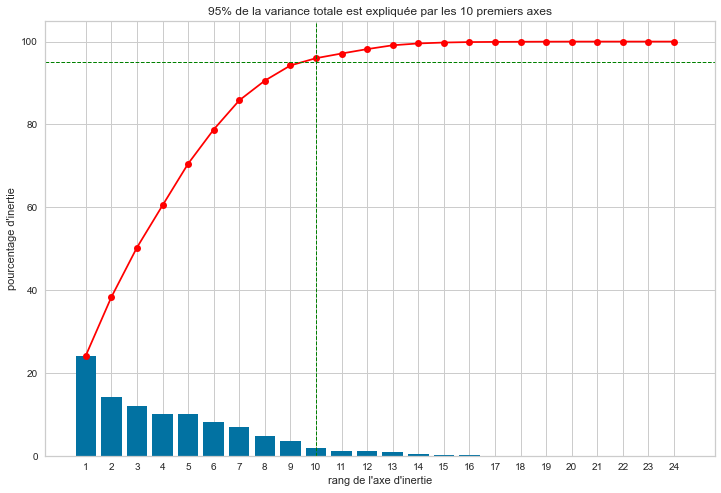

In [152]:
# selection des variables numériques

numerical_features = data.select_dtypes(include=['int64','float64', 'uint8'])
numerical_features_columns = numerical_features.columns 


# Standardisation des variables catégroielles MinMax scaled
scaler = MinMaxScaler()
data_scaled_1 = scaler.fit_transform(data[numerical_features_columns])
data_scaled_1 = pd.DataFrame(data_scaled_1, 
                             index=numerical_features.index, 
                             columns=numerical_features_columns)


# Modélisation PCA
from sklearn.decomposition import PCA
n_comp = len(data_scaled_1.columns)

pca = PCA(n_components=n_comp)
pca_results_1 = pca.fit_transform(data_scaled_1)



# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)


### Nombre de composantes 

In [134]:
pca = PCA(n_components=10)
pca_results_1 = pca.fit_transform(data_scaled_1)
pca_results_1.shape

(91019, 10)

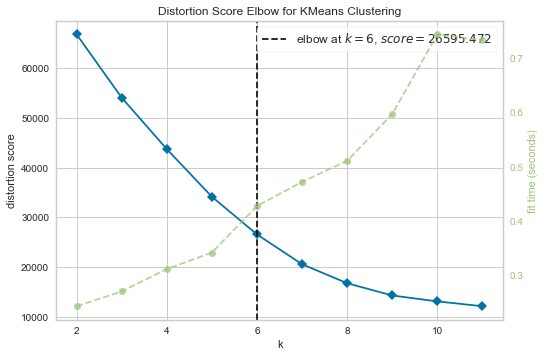

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [128]:
# Recherche du nombre de cluster optimal
# Méthode du coude 
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k = (2, 12))
visualizer.fit(pca_results_1)
visualizer.show()

In [130]:
from sklearn.cluster import KMeans

# Create a model based on 6 centroids
kmeans_1 = KMeans(n_clusters=6, init='k-means++', n_init=500, max_iter=1500)
# Fit to the data and predict the cluster assignments for each data point
km_clusters_1 = kmeans_1.fit_predict(pca_results_1)

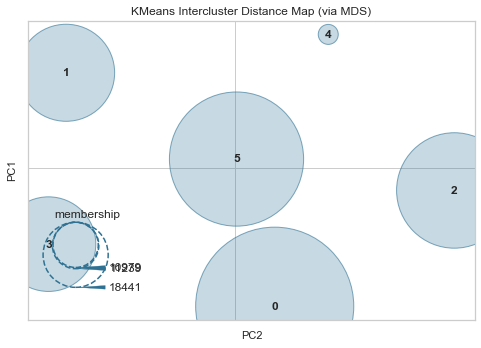

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [136]:
# Intercluster distance Map with best k

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

X = pca_results_1

distance_visualizer = InterclusterDistance(KMeans(6))
distance_visualizer.fit(X) # Fit the data to the visualizer
distance_visualizer.show()   # Finalize and render the figu

In [102]:
#numerical_features

In [164]:
data = olist_data.copy()
numerical_features = data.select_dtypes(include=['int64','float64', 'uint8'])

numerical_features_cat = numerical_features.copy()

numerical_features_cat["kmeans_label"] = km_clusters_1
numerical_features_cat_clusters = numerical_features_cat.groupby("kmeans_label").mean()
numerical_features_cat_clusters

,nb_orders_F,total_payment_value_M,mean_payment_sequential,mean_payment_installments,mean_review_score,means_delivery_vs_estimated,mean_delevery_days,mean_delay_days,mean_distance_sel_cust,freight_ratio,mean_order_value,customer_seniority_R,nb_product,mean_freight_value,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby
kmeans_label,,,,,,,,,,,,,,,,,,,,,,,,
0,1.019949,224.554957,1.020940,2.797164,4.193313,10.719263,8.578848,-11.719263,5.433134,0.204613,175.003350,206.758335,1.188923,21.492038,0.000137,0.000919,0.000560,0.000087,0.000935,0.002753,0.993313,0.000133,0.001051,0.000114
1,1.042351,237.953853,1.028825,3.210268,4.077070,10.852219,8.923674,-11.852219,5.087710,0.215793,155.170089,245.842380,1.359681,22.383131,0.000141,0.000627,0.000997,0.000160,0.000900,0.993209,0.001902,0.000194,0.001397,0.000473
2,1.022664,205.872535,1.018976,2.188217,4.090558,10.798755,9.179044,-11.798755,6.356062,0.260857,138.753194,241.323245,1.201033,17.906212,0.000036,0.000648,0.000397,0.000239,0.000557,0.001538,0.001058,0.000018,0.995410,0.000099
3,1.041210,173.595349,1.021199,2.614937,4.235444,10.994348,8.597427,-11.994348,5.397209,0.203625,139.137804,251.419098,1.200521,19.606800,0.045169,0.168705,0.001777,0.047909,0.001692,0.004081,0.001851,0.386737,0.001406,0.340675
4,1.027496,186.798413,1.018001,3.093839,4.243249,11.084402,8.562389,-12.084402,6.047926,0.188676,157.551803,228.275138,1.169336,18.433913,0.000178,0.000537,0.000386,0.000611,0.994322,0.001953,0.000942,0.000122,0.000868,0.000082
5,1.023519,241.100266,1.022332,3.563058,4.167909,11.027139,9.311631,-12.027139,6.007988,0.139877,213.112727,238.390938,1.133848,18.906834,0.000115,0.000653,0.992554,0.000023,0.000966,0.001864,0.001455,0.000100,0.001768,0.000503


In [165]:
plot_radars(data=numerical_features_cat_clusters, group="kmeans_label")

Malheureusement ici, la segmentation se base principalement sur les catégories de produit achetées. Le poids de ces features masque les autres axes de catégorisation, nous allons donc réaliser un nouveau K-Means en supprimant ces variables (nous pourrons ensuite ajouter la valeur la plus fréquente pour chaque groupe)

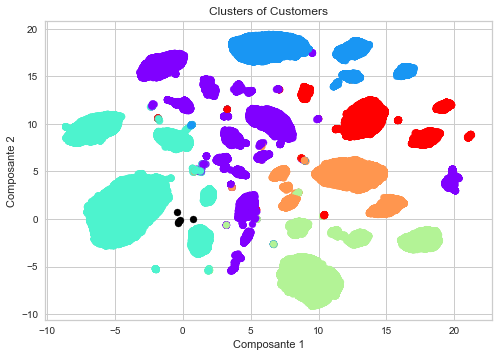

In [112]:
umap_results_1 = reduce_dimensions_umap(data_scaled_1)

X = umap_results_1


plt.scatter(X[:, 0], X[:, 1], c=kmeans_1.labels_, cmap='rainbow')
plt.scatter(kmeans_1.cluster_centers_[:,0], kmeans_1.cluster_centers_[:,1],  color='black')
plt.title("Clusters of Customers")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.show()

# Modélisation/Clustering sans catégories produits

In [ ]:
# suppression des variables
data.drop(columns = product_cat, inplace=True)

(91019, 14)


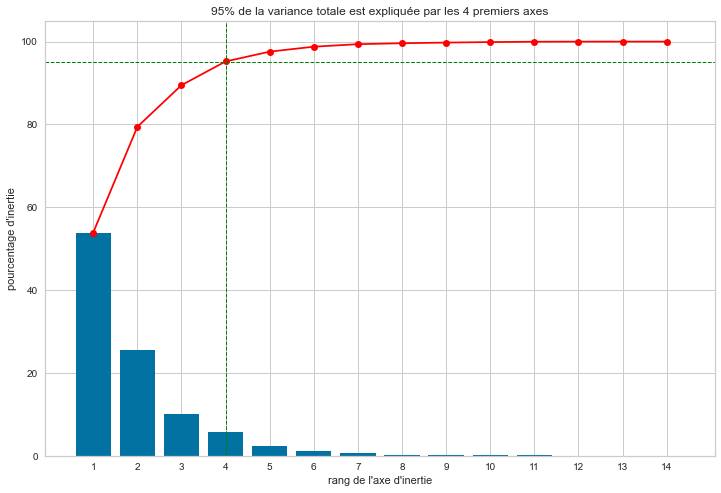

In [216]:
# selection des variables numériques
numerical_features = data.select_dtypes(include=['int64','float64', 'uint8'])


# Standardisation des variables catégroielles MinMax scaled
numerical_features_columns = numerical_features.columns 

scaler = MinMaxScaler()
data_scaled_2 = scaler.fit_transform(data[numerical_features_columns])
data_scaled_2 = pd.DataFrame(data_scaled_2,
                             index=numerical_features.index,
                             columns=numerical_features_columns)


# Modélisation PCA
from sklearn.decomposition import PCA
n_comp = len(data_scaled_2.columns)

pca = PCA(n_components=n_comp)
pca_results_2 = pca.fit_transform(data_scaled_2)
print(pca_results_2.shape)



#### Recherche du nombre de composantes optimale
# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [218]:
numerical_features.shape

(91019, 14)

#### Nombre de composante optimal

In [157]:
pca = PCA(n_components=4)
pca_results_2 = pca.fit_transform(data_scaled_2)
pca_results_2.shape

(91019, 4)

#### Recherche du nombre de cluster optimal

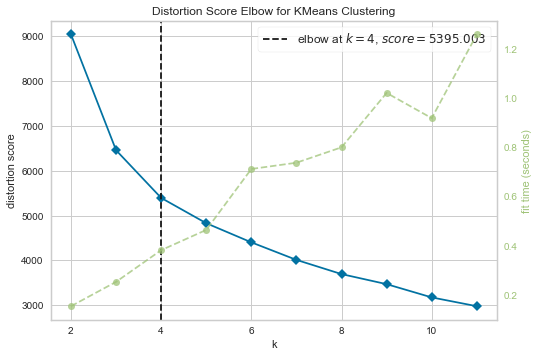

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [159]:
# Méthode du coude 

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k = (2, 12))
visualizer.fit(pca_results_2)
visualizer.show()

#### Modèle K-MEans

In [176]:
from sklearn.cluster import KMeans

# Create a model based on 4 centroids
kmeans_2 = KMeans(n_clusters=4, init='k-means++', n_init=500, max_iter=1500)
# Fit to the data and predict the cluster assignments for each data point
km_clusters_2 = kmeans_2.fit_predict(pca_results_2)

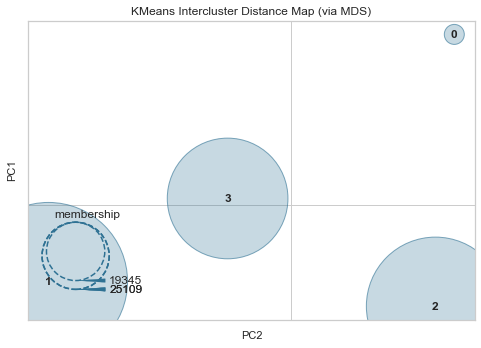

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [174]:
# Intercluster distance Map with best k

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

X = pca_results_2

distance_visualizer = InterclusterDistance(KMeans(4))
distance_visualizer.fit(X) # Fit the data to the visualizer
distance_visualizer.show()   # Finalize and render the figu

In [177]:
data = olist_data.copy()
data.drop(columns = product_cat, inplace=True)


numerical_features = data.select_dtypes(include=['int64','float64', 'uint8'])


numerical_features["kmeans_label"] = km_clusters_2

numerical_features_clusters = numerical_features.groupby("kmeans_label").mean()
numerical_features_clusters

,nb_orders_F,total_payment_value_M,mean_payment_sequential,mean_payment_installments,mean_review_score,means_delivery_vs_estimated,mean_delevery_days,mean_delay_days,mean_distance_sel_cust,freight_ratio,mean_order_value,customer_seniority_R,nb_product,mean_freight_value
kmeans_label,,,,,,,,,,,,,,
0,1.028761,204.531289,1.020902,2.749234,3.655257,10.297527,9.185411,-11.297527,5.733590,0.213819,151.086574,176.814918,1.222481,20.620620
1,1.054542,204.614738,1.028041,3.144542,4.706255,13.077193,7.834375,-14.077193,5.853206,0.204580,157.855342,423.072789,1.254185,19.523630
2,1.023709,317.749035,1.025076,3.158718,1.249418,4.120644,15.222179,-5.120644,6.264056,0.213831,185.532535,236.999138,1.416415,21.602953
3,1.022278,187.267590,1.019476,2.727290,4.998311,11.920338,7.272445,-12.920338,5.102882,0.206090,151.775250,140.267217,1.174293,20.011156


In [178]:
numerical_features["kmeans_label"].value_counts()

3    34878
1    25210
0    19332
2    11599
Name: kmeans_label, dtype: int64

In [179]:
plot_radars(data=numerical_features_clusters, group="kmeans_label")

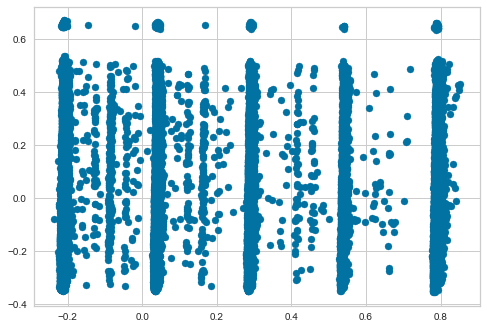

In [205]:
#plt.figure(figsize=(12,8))

plt.scatter(pca_results_2[:,0], pca_results_2[:,1], c='b')

In [172]:
#@title
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap 


def reduce_dimensions_umap(df):
    reducer = umap.UMAP(metric="cosine")
    embedding = reducer.fit_transform(df)
    return embedding


umap_results_2 = reduce_dimensions_umap(data_scaled_2)

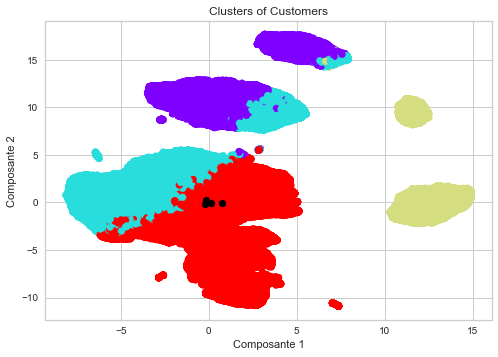

In [180]:
X = umap_results_2

#marker="$%d$" % i,

plt.scatter(X[:, 0], X[:, 1], c=kmeans_2.labels_, cmap='rainbow')
plt.scatter(kmeans_2.cluster_centers_[:,0], kmeans_2.cluster_centers_[:,1],  color='black')
plt.title("Clusters of Customers")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.show()

In [201]:
from sklearn.manifold import TSNE

time_start = time.time()

tsne_2 = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results_2 = tsne_2.fit_transform(data_scaled_2)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 91019 samples in 0.109s...
[t-SNE] Computed neighbors for 91019 samples in 55.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 91019
[t-SNE] Computed conditional probabilities for sample 2000 / 91019
[t-SNE] Computed conditional probabilities for sample 3000 / 91019
[t-SNE] Computed conditional probabilities for sample 4000 / 91019
[t-SNE] Computed conditional probabilities for sample 5000 / 91019
[t-SNE] Computed conditional probabilities for sample 6000 / 91019
[t-SNE] Computed conditional probabilities for sample 7000 / 91019
[t-SNE] Computed conditional probabilities for sample 8000 / 91019
[t-SNE] Computed conditional probabilities for sample 9000 / 91019
[t-SNE] Computed conditional probabilities for sample 10000 / 91019
[t-SNE] Computed conditional probabilities for sample 11000 / 91019
[t-SNE] Computed conditional probabilities for sample 12000 / 91019
[t-SNE] Computed conditional probabilities for s

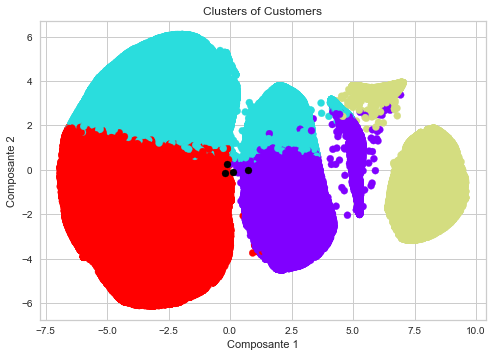

In [206]:
X = tsne_results_2

#marker="$%d$" % i,

plt.scatter(X[:, 0], X[:, 1], c=kmeans_2.labels_, cmap='rainbow')
plt.scatter(kmeans_2.cluster_centers_[:,0], kmeans_2.cluster_centers_[:,1],  color='black')
plt.title("Clusters of Customers")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.show()

## Modélisation Numérique + Catégorielle _ sans cat produits

In [181]:
data = olist_data.copy()

# suppression des variables
data.drop(columns = product_cat, inplace=True)


X = data.copy()

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


### Normalisation des variables numériques
def standard_scaler(df):
    ss = StandardScaler()
    numerical_columns = df.select_dtypes(['float64','int64']).columns
    for col in numerical_columns:
        df[numerical_columns] = ss.fit_transform(df[numerical_columns])
    return df

standard_scaler(X).head()

,nb_orders_F,total_payment_value_M,mean_payment_sequential,mean_payment_installments,mean_review_score,means_delivery_vs_estimated,mean_delevery_days,mean_delay_days,mean_distance_sel_cust,freight_ratio,mean_order_value,customer_seniority_R,nb_product,mean_freight_value,most_purchase_category,most_payment_used,often_is_delayed,most_purchase_region,most_purchase_month_N,most_purchase_dayofweek_N,most_purchase_timeday
0,-0.159161,-0.111415,-0.123514,1.902649,0.660893,-0.685248,-0.559061,0.685248,-0.841710,-1.027607,-0.072852,-0.833770,-0.281152,-0.521235,home_furniture,Credit Card,False,Southeast,May,Thu,Morning
1,-0.159161,-0.292782,-0.123514,-0.710110,-0.120693,-0.685248,-0.905053,0.685248,-0.991758,0.734467,-0.604636,-0.814180,-0.281152,-0.756820,health_beauty,Credit Card,False,Southeast,May,Mon,Morning
2,-0.159161,-0.199450,-0.123514,1.902649,-0.902279,-0.983090,1.632220,0.983090,-0.160994,-0.066476,-0.330979,1.941395,-0.281152,-0.189765,other,Credit Card,False,South,Mar,Fri,Night
3,-0.159161,-0.266804,-0.123514,0.409644,-0.120693,0.009717,1.170898,-0.009717,3.088601,1.535410,-0.528468,0.530958,-0.281152,-0.163730,technology,Credit Card,False,North,Oct,Thu,Night
4,-0.159161,-0.024470,-0.123514,1.156146,0.660893,-0.387406,0.248253,0.387406,-0.754661,-0.947513,0.182075,0.315475,-0.281152,-0.210720,technology,Credit Card,False,Southeast,Nov,Tue,Night


In [182]:
### Encodage des variables catégorielles

def Label_Encoder(df):
    
    labelEnc=preprocessing.LabelEncoder()
    catagorical_columns = df.select_dtypes(['bool','object']).columns.tolist()
    
    for col in catagorical_columns:
        df[col]=labelEnc.fit_transform(df[col])
        
    return df

Label_Encoder(X).head()

,nb_orders_F,total_payment_value_M,mean_payment_sequential,mean_payment_installments,mean_review_score,means_delivery_vs_estimated,mean_delevery_days,mean_delay_days,mean_distance_sel_cust,freight_ratio,mean_order_value,customer_seniority_R,nb_product,mean_freight_value,most_purchase_category,most_payment_used,often_is_delayed,most_purchase_region,most_purchase_month_N,most_purchase_dayofweek_N,most_purchase_timeday
0,-0.159161,-0.111415,-0.123514,1.902649,0.660893,-0.685248,-0.559061,0.685248,-0.841710,-1.027607,-0.072852,-0.833770,-0.281152,-0.521235,5,1,0,4,8,4,2
1,-0.159161,-0.292782,-0.123514,-0.710110,-0.120693,-0.685248,-0.905053,0.685248,-0.991758,0.734467,-0.604636,-0.814180,-0.281152,-0.756820,4,1,0,4,8,1,2
2,-0.159161,-0.199450,-0.123514,1.902649,-0.902279,-0.983090,1.632220,0.983090,-0.160994,-0.066476,-0.330979,1.941395,-0.281152,-0.189765,6,1,0,3,7,0,3
3,-0.159161,-0.266804,-0.123514,0.409644,-0.120693,0.009717,1.170898,-0.009717,3.088601,1.535410,-0.528468,0.530958,-0.281152,-0.163730,8,1,0,1,10,4,3
4,-0.159161,-0.024470,-0.123514,1.156146,0.660893,-0.387406,0.248253,0.387406,-0.754661,-0.947513,0.182075,0.315475,-0.281152,-0.210720,8,1,0,4,9,5,3


In [183]:
X.head()

,nb_orders_F,total_payment_value_M,mean_payment_sequential,mean_payment_installments,mean_review_score,means_delivery_vs_estimated,mean_delevery_days,mean_delay_days,mean_distance_sel_cust,freight_ratio,mean_order_value,customer_seniority_R,nb_product,mean_freight_value,most_purchase_category,most_payment_used,often_is_delayed,most_purchase_region,most_purchase_month_N,most_purchase_dayofweek_N,most_purchase_timeday
0,-0.159161,-0.111415,-0.123514,1.902649,0.660893,-0.685248,-0.559061,0.685248,-0.841710,-1.027607,-0.072852,-0.833770,-0.281152,-0.521235,5,1,0,4,8,4,2
1,-0.159161,-0.292782,-0.123514,-0.710110,-0.120693,-0.685248,-0.905053,0.685248,-0.991758,0.734467,-0.604636,-0.814180,-0.281152,-0.756820,4,1,0,4,8,1,2
2,-0.159161,-0.199450,-0.123514,1.902649,-0.902279,-0.983090,1.632220,0.983090,-0.160994,-0.066476,-0.330979,1.941395,-0.281152,-0.189765,6,1,0,3,7,0,3
3,-0.159161,-0.266804,-0.123514,0.409644,-0.120693,0.009717,1.170898,-0.009717,3.088601,1.535410,-0.528468,0.530958,-0.281152,-0.163730,8,1,0,1,10,4,3
4,-0.159161,-0.024470,-0.123514,1.156146,0.660893,-0.387406,0.248253,0.387406,-0.754661,-0.947513,0.182075,0.315475,-0.281152,-0.210720,8,1,0,4,9,5,3


### Réduction dimensionnelle - PCA

Nous allons réaliser une Analyse en Composantes Principales pour vérifier s'il est possible de catégoriser nos clients avec moins de variables. L'objectif étant de conserver une inertie de 95%

In [56]:
# reduce dimensions via pca
def reduce_dimensions_pca(df, num_features):
    num_features = min(num_features, df.shape[1])
    pca = PCA(n_components=num_features)
    pca = pca.fit(df.values)
    pca_result = pca.transform(df.values)
    print("Explained variation per principal component: ",
          np.sum(pca.explained_variance_ratio_), pca_result.shape)
    print(" > PCA Complete ===========", df.shape)
    return pca, pca_result

In [168]:
#data_scaled = X[["customer_seniority_R", "nb_orders_F", "total_payment_value_M"]]

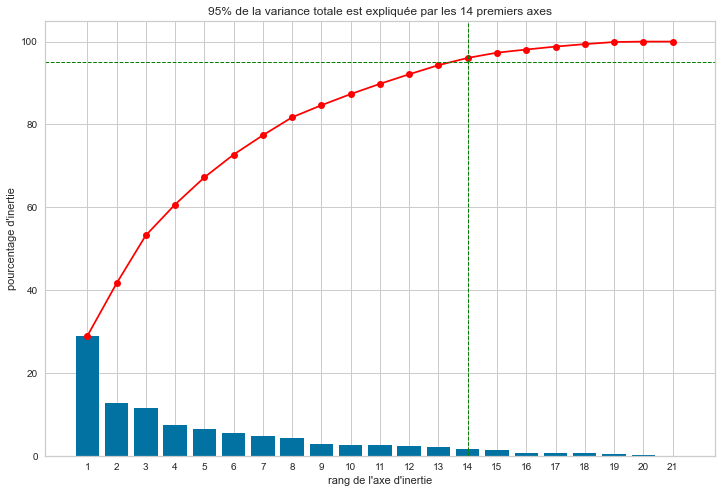

In [186]:
from sklearn.decomposition import PCA


data_transformed = X.copy()

n_comp = len(data_transformed.columns)

pca = PCA(n_components=n_comp)
pca_results_3 = pca.fit_transform(data_transformed)
pca_results_3.shape

# Explained variance
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [187]:
n_comp = 14 

pca = PCA(n_components=n_comp )
pca_results_3 = pca.fit_transform(data_transformed)
features = data_transformed.columns
pcs = pca.components_
columns = ['pca_comp_%i' % i for i in range(n_comp)]

df_pca = pd.DataFrame(pca_results_3, columns=columns, index=data_transformed.index)
print(df_pca.shape)
df_pca.head()

(91019, 14)


,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,pca_comp_10,pca_comp_11,pca_comp_12,pca_comp_13
0,2.845537,0.640497,-0.951852,-0.174094,-0.791425,1.367558,-1.240851,0.533673,-0.218018,-0.599744,-1.557078,-0.841827,0.200535,0.923181
1,2.880342,1.123221,2.042104,-0.490627,-2.077751,0.069111,0.051979,0.488357,-0.984334,0.856519,0.103517,-0.159077,0.109995,0.379713
2,2.149360,-0.698403,3.049184,1.946113,-0.426766,0.102673,-0.431722,1.573031,2.008854,-1.525850,0.309326,-0.406615,-0.335554,0.921912
3,4.954965,-2.767983,-1.112824,1.792427,1.533809,-3.123207,0.527395,1.488257,0.495287,-0.200682,-0.337475,0.038156,0.673722,0.959989
4,3.890155,-2.326717,-2.117288,-0.074687,-0.297507,1.254411,-1.169494,1.550376,0.451599,-0.770157,-0.968772,-0.107503,-0.229743,0.340598


### Cercle des corrélations

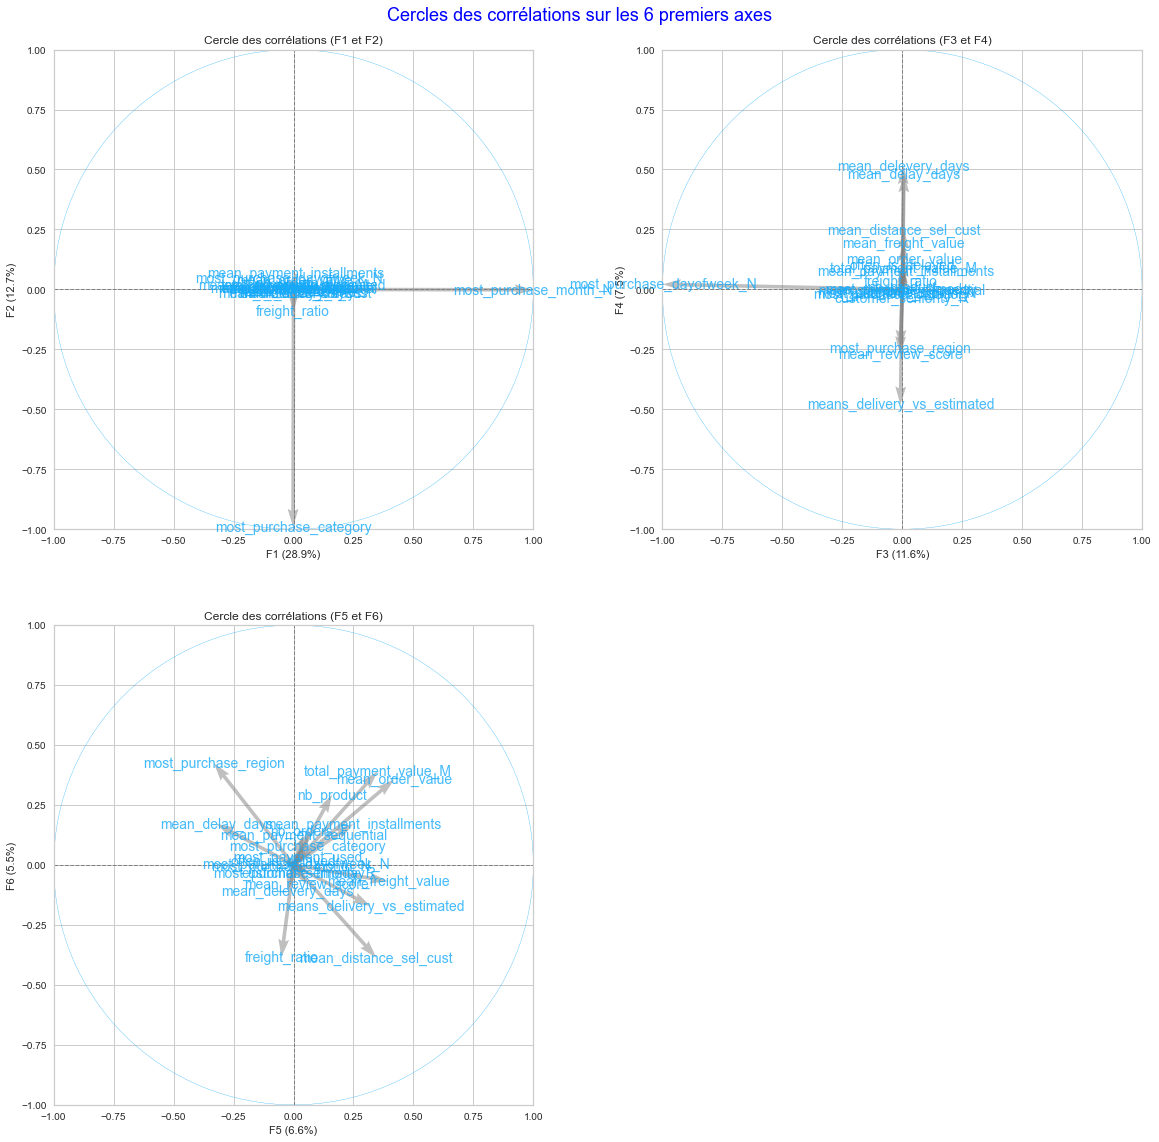

In [215]:
#display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

# Principal component space
pcs = pca.components_

# Plot correlation circle
cerle_corr(pcs, 6, pca,  [(0,1),(2,3),(4,5)], labels = np.array(data_transformed.columns))

On peut ainsi voir parfaitement les variables qui contribuent le plus à chaque axe. Par exemple : 

 - La variable synthétique F5 représentera les périodes d'achats.

-  La variable synthétique F6 quant à elle représente l'aspect géographique.

Nous allons donc intégrer à notre pipeline Kmeans une PCA sur `14 composantes` pour vérifier si la réduction dimensionnelle réduit la qualité de la segmentation

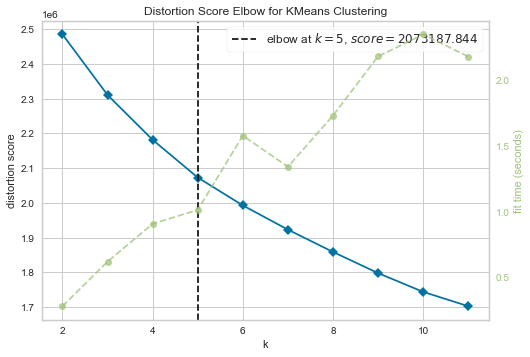

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [188]:
# Méthode du coude 

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k = (2, 12))
visualizer.fit(df_pca)
visualizer.show()

Grâce à la méthode du coude basée sur le score de distortion (somme moyenne des carrés des distances aux centres), une segementation en **K=5 clusters** serait la meilleure option

### Distances intercluster

In [190]:
from sklearn.cluster import KMeans

# Create a model based on 5 centroids
kmeans_3 = KMeans(n_clusters=5, init='k-means++', n_init=500, max_iter=1500)
# Fit to the data and predict the cluster assignments for each data point
km_clusters_3 = kmeans_3.fit_predict(df_pca)

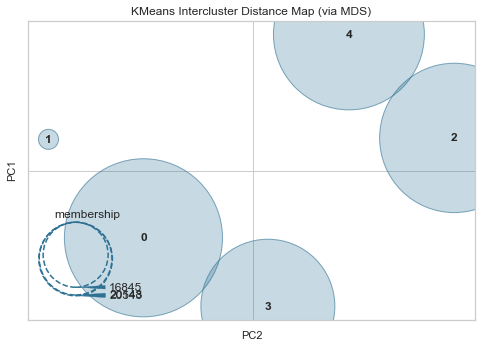

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [193]:
# Intercluster distance Map with best k

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

X = pca_results_3

distance_visualizer = InterclusterDistance(KMeans(5))
distance_visualizer.fit(X) # Fit the data to the visualizer
distance_visualizer.show()   # Finalize and render the figu

Sur cette projection en 2D, on remarque que les différents clusters sont bien séparés sur les 2 premières composantes principales. Le clustering semble donc performant et il faut a présent identifier les composantes métier de chaque cluster.

Analyse des différents clusters

A présent, nous allons entrainer notre KMeans avec le K optimal sélectionné et affecter son cluster à chaque client. Ainsi, nous pourrons analyser les différences entre chaque cluster :


Nous allons dans un premier temps grouper les individus par cluster pour analyser les moyennes :


Projetons à présent ces différentes moyennes sur un Radar plot avec la librairie Ploty pour visualiser les différences entre cluster :

In [194]:
data_all_features =  olist_data.copy()
data_all_features.drop(columns = product_cat, inplace=True)


data_all_features["kmeans_label"] = km_clusters_3
data_all_features_clusters = data_all_features.groupby("kmeans_label").mean()
data_all_features_clusters

,nb_orders_F,total_payment_value_M,mean_payment_sequential,mean_payment_installments,mean_review_score,means_delivery_vs_estimated,mean_delevery_days,mean_delay_days,mean_distance_sel_cust,freight_ratio,mean_order_value,customer_seniority_R,nb_product,mean_freight_value,often_is_delayed
kmeans_label,,,,,,,,,,,,,,,
0,1.030246,201.652439,1.021544,2.814016,4.151763,11.013541,8.928325,-12.013541,5.663147,0.210183,154.616071,223.147306,1.224286,20.254730,0.076633
1,1.033501,206.674702,1.019848,2.789832,4.160759,10.792329,9.034955,-11.792329,5.437484,0.207801,152.826489,223.539076,1.232897,19.678347,0.080197
2,1.032835,225.002695,1.025063,2.957634,4.098697,10.332471,9.115327,-11.332471,5.663214,0.218070,157.171892,271.662748,1.260717,20.629873,0.093813
3,1.039879,214.841221,1.021885,3.315631,4.218285,11.548771,8.664511,-12.548771,5.864257,0.169457,182.888068,246.255922,1.174426,19.160427,0.071344
4,1.030879,216.477132,1.025623,2.842690,4.161668,11.014479,8.493498,-12.014479,5.486678,0.218597,152.735752,238.060030,1.266746,20.842539,0.076112


#### Interprétation métier des clusters

- Groupe 1 : Clients proches géographiquement avec de courts délais de livraison, commandant principalement en début d'année pour des montants faibles. Ils paient avec 1 type de moyen de paiement et avec un nombre faible d'échéances. Les avis de ces clients sont très bons.

- Groupe 2 : Clients de fin d'année. Ils règlent avec plusieurs moyens de paiement pour des montants faibles. Ces clients sont géographiquement peu éloignés et les délais de livraison sont courts. Les avis de ces clients sont également très bons.

- Groupe 3 : Regroupe les clients qui utilisent plusieurs moyens de paiement et un nombre important d'échéances. Ils ont tendence à espacer les délais entre 2 commandes. Les avis de ces clients sont également très bons.

- Groupe 4 : Ce sont des clients mécontants (les avis sont mauvais). Les délais de livraison sont très importants et les frais de port élevés en raison de l'éloignement géographique. Ce sont cependant les clients qui ont le plus dépensé et ont acheté un grand nombre d'articles. En revanche, le nombre de commandes passées sur le site est moyen.

- Groupe 5 : Ces clients ont passé un nombre important de commandes et sont satisfaits. ils paient comptant pour un montant moyen de commande. Ils sont géographiquement proches.

In [195]:
plot_radars(data=data_all_features_clusters, group="kmeans_label")

####  Visualisation 2D ACP

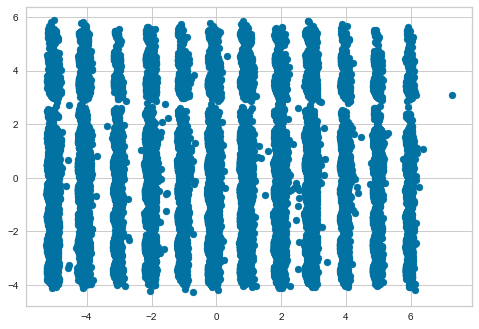

In [196]:
#plt.figure(figsize=(12,8))

plt.scatter(pca_results_3[:,0], pca_results_3[:,1], c='b')

#### Visualisation 2D UMAP

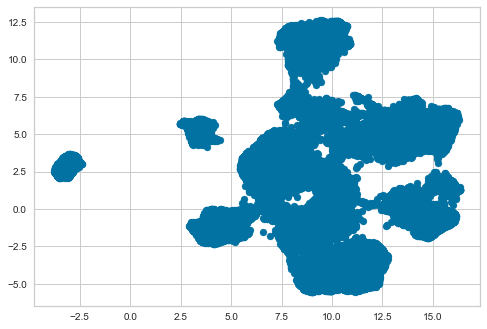

In [197]:
umap_results_3 = reduce_dimensions_umap(data_transformed)

plt.scatter(umap_results_3[:,0], umap_results_3[:,1], c='b')
#plt.colorbar()
plt.show()

#### Visualisation 2D TSNE

In [198]:
from sklearn.manifold import TSNE

time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(data_transformed)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 91019 samples in 0.002s...
[t-SNE] Computed neighbors for 91019 samples in 151.650s...
[t-SNE] Computed conditional probabilities for sample 1000 / 91019
[t-SNE] Computed conditional probabilities for sample 2000 / 91019
[t-SNE] Computed conditional probabilities for sample 3000 / 91019
[t-SNE] Computed conditional probabilities for sample 4000 / 91019
[t-SNE] Computed conditional probabilities for sample 5000 / 91019
[t-SNE] Computed conditional probabilities for sample 6000 / 91019
[t-SNE] Computed conditional probabilities for sample 7000 / 91019
[t-SNE] Computed conditional probabilities for sample 8000 / 91019
[t-SNE] Computed conditional probabilities for sample 9000 / 91019
[t-SNE] Computed conditional probabilities for sample 10000 / 91019
[t-SNE] Computed conditional probabilities for sample 11000 / 91019
[t-SNE] Computed conditional probabilities for sample 12000 / 91019
[t-SNE] Computed conditional probabilities for 

In [199]:
columns= ["DIM" + str(c) for c in range(1, tsne_results.shape[1]+1, 1)]
df_tse = pd.DataFrame(tsne_results, columns=columns, index=data_scaled.index)
print(df_tse.shape)
#df_tse.head()

#df_tse.plot(x='DIM1', y='DIM2', kind='scatter', figsize=(5,5), c='b')

(91019, 2)


<AxesSubplot:xlabel='DIM1', ylabel='DIM2'>

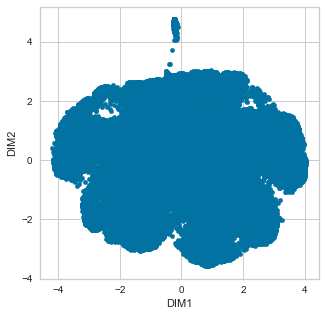

In [200]:
df_tse.plot(x='DIM1', y='DIM2', kind='scatter', figsize=(5,5), c='b')

### Coefficient de silhouette
Pour vérifier si ce clustering fonctionne, nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster. Cela permet de visualiser la densité et la séparation des clusters.

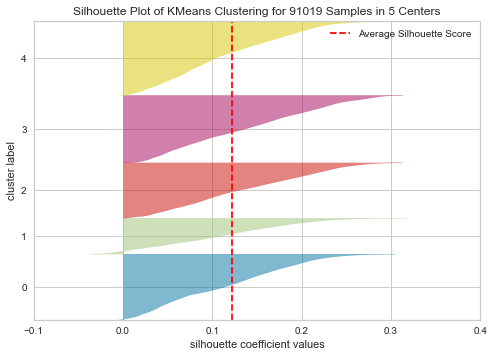

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91019 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [208]:
X = pca_results_3

model = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

On remarque donc ici que la réduction de dimenssion offre les mêmes axes de segmentation. Il est donc possible de réduire le nombre de features en entrée et d'utiliser les variables synthétiques de la PCA pour segmenter notre fichier client, ce d'autant que les scores silhouette sont ici meilleurs comparés au données brutes.

### Stabilité à l'initialisation du K-Means

Notre algorithme du K-Means testé ici est initialisé avec la méthode K-Means++, ce qui réduit déjà les effets aléatoires de l'initialisation des centroïdes. Cependant, vous allons tester la stabilité à l'initialisation en entrainant plusieurs fois le modèle sans fixer le RandomState.

Pour les labels initiaux, nous allons conserver les clusters calculés dans le dernier modèle (avec PCA) puis les comparer grâce à l'indice de Rand ajusté (ARI) pour chacune des itérations

In [285]:
labels = pca_kmeans_labels
pca_data = X_projected[:,:4]

In [291]:
from time import time
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score


def bench_k_means(model, name, data, labels):
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[1].inertia_]
    
    # Test differents metrics on pred labels
    clustering_metrics = [
        homogeneity_score,
        adjusted_rand_score,
        adjusted_mutual_info_score]
    results += [m(labels, estimator[1].labels_) for m in clustering_metrics]
    
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [292]:
print("Scores de stabilité à l'initialisation")
print(53 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(53 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=K, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name="Iter "+str(i), 
                  data=pca_data, labels=labels)

print(53 * '_')

Scores de stabilité à l'initialisation
_____________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_____________________________________________________
Iter 0   	0.268s	5145	1.000	1.000	1.000
Iter 1   	0.074s	5145	1.000	1.000	1.000
Iter 2   	0.093s	5948	0.680	0.593	0.688
Iter 3   	0.066s	6099	0.662	0.530	0.688
Iter 4   	0.073s	5145	1.000	1.000	1.000
Iter 5   	0.074s	5145	1.000	1.000	1.000
Iter 6   	0.078s	5145	1.000	1.000	1.000
Iter 7   	0.075s	5876	0.608	0.559	0.624
Iter 8   	0.057s	5145	1.000	1.000	1.000
Iter 9   	0.060s	5145	1.000	1.000	1.000
_____________________________________________________


Les différentes itérations montrent des inerties proches, une bonne homogénéité et un score AMI proche de 1. Nous pouvons donc en déduire que la stabilité à l'initialisation du modèle K-Means est bonne

### Maintenance

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

Pour cela, nous devons recalculer toutes les features en fonction d'une période donnée. Le script réalisant ces calculs ce trouve ci-dessous

In [101]:
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [304]:
from math import radians, cos, sin, asin, sqrt

def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    """The haversine formula makes it possible to determine the distance of the great circle 
        between two points of a sphere, from their longitudes and latitudes.

    Parameters
    ----------
    lat1, lat2 : float
        Latitudes of the 2 coordinate points to compare. 
    lng1, lng2 : float
        Longitudes of the 2 coordinate points to compare.
    degrees : boolean
        If True, converts radians to degrees.
    """
    # Radius of the earth in miles
    r = 3956 
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Haversine formula
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

In [305]:
from time import time

def make_dataset(dpath="dataset/", initial=False, period=2):
    """Cleaning and feature engineering on complete Olist data 
        for preparation of unsupervised classification (K-Means).

    Parameters
    ----------
    dpath : str
        Path to the directory containing the data.
    initial : boolean
        Defines whether the created dataset is the initial dataset.
    period : int
        Increment period in months after initial dataset.
    """
    start_time = time()
    print("Création du dataset en cours ...")
    
    # Root path
    root_path = dpath
    
    # Load datasets
    customers = pd.read_csv(root_path + "olist_customers_dataset.csv")
    geolocation = pd.read_csv(root_path + "olist_geolocation_dataset.csv")
    orders = pd.read_csv(root_path + "olist_orders_dataset.csv")
    order_items = pd.read_csv(root_path + "olist_order_items_dataset.csv")
    order_payments = pd.read_csv(root_path + "olist_order_payments_dataset.csv")
    order_reviews = pd.read_csv(root_path + "olist_order_reviews_dataset.csv")
    products = pd.read_csv(root_path + "olist_products_dataset.csv")
    categories_en = pd.read_csv(root_path + "product_category_name_translation.csv")
    
    # Group location 
    geolocation = geolocation.groupby(["geolocation_state"]).agg({
            "geolocation_lat": "mean",
            "geolocation_lng": "mean"})
    
    # Merge datasets
    # Orders
    orders.drop(["order_approved_at",
                 "order_delivered_carrier_date", 
                 "order_estimated_delivery_date"],
                axis=1, inplace=True)

    order_items.drop(["seller_id",
                      "shipping_limit_date"],
                     axis=1, inplace=True)
    order_items = pd.merge(order_items, orders,
                           how="left",
                           on="order_id")
    
    datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date"]
    for col in datetime_cols:
        order_items[col] = order_items[col].astype('datetime64[ns]')
        
    # order Month
    order_items["sale_month"] = order_items['order_purchase_timestamp'].dt.month
    
    # Select orders on period
    start=order_items["order_purchase_timestamp"].min()
    if(initial == True):
        period = 12
    else:
        period = 12+period
    stop=start + pd.DateOffset(months=period)
        
    order_items = order_items[(order_items["order_purchase_timestamp"]>=start)
                              & (order_items["order_purchase_timestamp"]<stop)]
    
    # List of orders on period
    period_orders = order_items.order_id.unique()
    
    # Calculate other features on period
    order_payments = order_payments[order_payments["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items, 
                           order_payments.groupby(by="order_id").agg(
                               {"payment_sequential": 'count',
                                "payment_installments": 'sum'}),
                           how="left",
                           on="order_id")
    order_items = order_items.rename(columns={
        "payment_sequential": "nb_payment_sequential",
        "payment_installments": "sum_payment_installments"})
    
    order_reviews = order_reviews[order_reviews["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items,
                           order_reviews.groupby("order_id").agg({
                               "review_score": "mean"}),
                           how="left",
                           on="order_id")
    
    # Delivery time
    order_items["delivery_delta_days"] = (order_items.order_delivered_customer_date
                                          - order_items.order_purchase_timestamp)\
                                         .dt.round('1d').dt.days
    order_items.drop("order_delivered_customer_date", axis=1, inplace=True)
    
    # Products
    products = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

    del_features_list = ["product_category_name", "product_weight_g",
                         "product_length_cm", "product_height_cm",
                         "product_width_cm", "product_name_lenght", 
                         "product_description_lenght", "product_photos_qty"]
    products.drop(del_features_list, axis=1, inplace=True)
    products = products.rename(columns={"product_category_name_english":
                                        "product_category_name"})
        
    products['product_category'] = np.where((products['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                            np.where((products['product_category_name'].str.contains("health|beauty|perfum")==True),
                                     'health_beauty',
                            np.where((products['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                            np.where((products['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                            np.where((products['product_category_name'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                            np.where((products['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                            np.where((products['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                     'home_furniture',
                            np.where((products['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                            np.where((products['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))
    products.drop("product_category_name", axis=1, inplace=True)

    order_items = pd.merge(order_items, products, 
                           how="left",
                           on="product_id")
    
    # Encode categories column
    order_items = pd.get_dummies(order_items, columns=["product_category"], prefix="", prefix_sep="")
    
    # Customers
    order_items = pd.merge(order_items, customers[["customer_id",
                                                   "customer_unique_id",
                                                   "customer_state"]],
                           on="customer_id",
                           how="left")
    
    # Group datas by unique customers
    data = order_items.groupby(["customer_unique_id"]).agg(
        nb_orders=pd.NamedAgg(column="order_id", aggfunc="nunique"),
        total_items=pd.NamedAgg(column="order_item_id", aggfunc="count"),
        total_spend=pd.NamedAgg(column="price", aggfunc="sum"),
        total_freight=pd.NamedAgg(column="freight_value", aggfunc="sum"),
        mean_payment_sequential=pd.NamedAgg(column="nb_payment_sequential", aggfunc="mean"),
        mean_payment_installments=pd.NamedAgg(column="sum_payment_installments", aggfunc="mean"),
        mean_review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        mean_delivery_days=pd.NamedAgg(column="delivery_delta_days", aggfunc="mean"),
        books_cds_media=pd.NamedAgg(column="books_cds_media", aggfunc="sum"),
        fashion_clothing_accessories=pd.NamedAgg(column="fashion_clothing_accessories", aggfunc="sum"),
        flowers_gifts=pd.NamedAgg(column="flowers_gifts", aggfunc="sum"),
        groceries_food_drink=pd.NamedAgg(column="groceries_food_drink", aggfunc="sum"),
        health_beauty=pd.NamedAgg(column="health_beauty", aggfunc="sum"),
        home_furniture=pd.NamedAgg(column="home_furniture", aggfunc="sum"),
        other=pd.NamedAgg(column="other", aggfunc="sum"),
        sport=pd.NamedAgg(column="sport", aggfunc="sum"),
        technology=pd.NamedAgg(column="technology", aggfunc="sum"),
        toys_baby=pd.NamedAgg(column="toys_baby", aggfunc="sum"),
        customer_state=pd.NamedAgg(column="customer_state", aggfunc="max"),
        first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
        last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
        favorite_sale_month=pd.NamedAgg(column="sale_month", 
                                        aggfunc=lambda x:x.value_counts().index[0]))
    
    # Final feature engineering
    # Categories items ratio
    cat_features = data.columns[7:17]
    for c in cat_features:
        data[c] = data[c] / data["total_items"]
    
    # Mean delay between 2 orders
    data["order_mean_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0]
                                else (stop - y[0]).round('1d').days
                                for x,y in data[["first_order","last_order"]].iterrows()]
    data["order_mean_delay"] = data["order_mean_delay"] / data["nb_orders"]
    data.drop(["first_order", "last_order"], axis=1, inplace=True)
    
    # Freight ratio and total price
    data["freight_ratio"] = (round(data["total_freight"] / (data["total_spend"] + data["total_freight"]),2))
    data["total_spend"] = (data["total_spend"] + data["total_freight"])
    data.drop("total_freight", axis=1, inplace=True)
    
    # Add Haversine distance of customer state
    # Haversine distance
    olist_lat = -25.43045
    olist_lon = -49.29207
        
    geolocation['haversine_distance'] = [haversine_distance(olist_lat, olist_lon, x, y)
                                         for x, y in zip(geolocation.geolocation_lat,
                                                         geolocation.geolocation_lng)]
    data = pd.merge(data.reset_index(), geolocation[["haversine_distance"]],
                    how="left",
                    left_on="customer_state",
                    right_on="geolocation_state")
    data.drop(["customer_state"], axis=1, inplace=True)
    data.set_index("customer_unique_id", inplace=True)
    
    # complete missing values
    features_to_fill = data.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)
    
    print(54*"_")
    print("Features complétées avec la valeur la plus fréquente :")
    print(54*"_")
    for f in features_to_fill:
        data[f] = data[f].fillna(data[f].mode()[0])
        print(f,"\t", data[f].mode()[0])
    print(54*"_")
    
    end_time = time()
    print("Durée d'execution du Feature engineering : {:.2f}s".format(end_time - start_time))
    
    return data

### Période Initiale 

In [306]:
# Initial period of 12 months
data_init = make_dataset(dpath="dataset/", initial=False, period=2)

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 123.72s


In [307]:
data_init.head()

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,3,239.0,0.20,125.363853
0000f6ccb0745a6a4b88665a16c9f078,1,1,43.62,1.0,4.0,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,10,23.0,0.40,1574.231129
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,245.0,0.10,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,7,109.0,0.52,669.215559
000a5ad9c4601d2bbdd9ed765d5213b3,1,1,91.28,1.0,3.0,4.0,11.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,8,85.0,0.16,337.899660


### Période Totale à couvrie

In [121]:
#data_period[data_period.index.isin(data_init.index)]

Nous allons ensuite déterminer la période totale à couvrir

In [308]:
olist_path = "dataset/"

orders = pd.read_csv(olist_path+"olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", "order_purchase_timestamp"]

orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


Pour déterminer le moment où les clients changent de cluster, nous allons itérer le K-Means sur toute la période avec des deltas de 2 mois et calculer le score ARI, en prenant garde à bien comparer les mêmes clients (ceux des 12 mois initiaux).

Ici le déroulé est créé directement dans le notebook pour explication, en production, toutes ses opérations seront regroupées dans une classe Python pour automatiser le processus.

In [309]:
# Kmeans on initial period
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [310]:
ari_score = []
for p in np.arange(2,(time_delta-12),2):
    # Create dataset for period
    data_period = make_dataset(dpath="dataset/", initial=False, period=p)
    data_period.drop(categories_col, axis=1, inplace=True)
    
    # Filter on initial customer client
    data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(5, random_state=42))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p,ari_p])

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 43.19s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 21.96s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
_____________________________

In [311]:
ari_score

[[2, 0.006667742938796133],
 [4, 0.006887833746992902],
 [6, 0.006889804683351356],
 [8, 0.004682666627998053],
 [10, 0.004607719622432594]]

In [312]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])
ari_score

,periode,ARI
0,2,0.006668
1,4,0.006888
2,6,0.006890
3,8,0.004683
4,10,0.004608


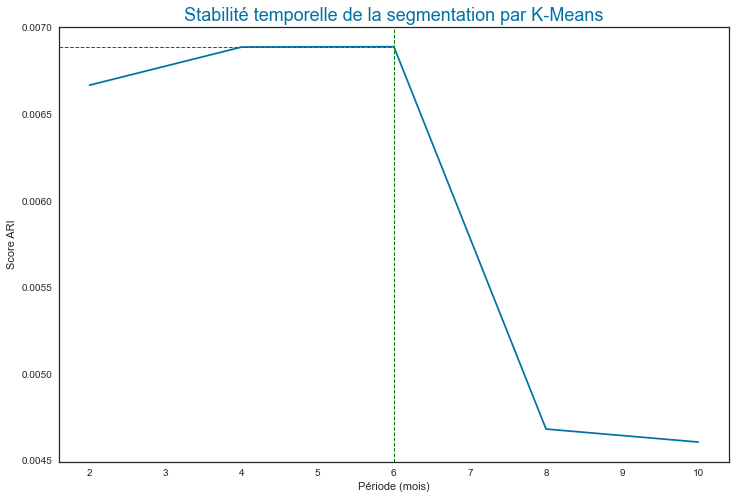

In [313]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()